**Before running this notebook**, make sure to have a proper Nvidia GPU driver (https://www.nvidia.com/Download/index.aspx) as well as the CUDA toolkit (https://developer.nvidia.com/cuda-toolkit) installed.

Then, make sure to create an environment with Pytorch > v1.8.8 following these instructions to enable CUDA.

https://pytorch.org/get-started/locally/

Once you have everything install, run the next block of code before everything

In [1]:
import tensorly as tl
tl.set_backend('pytorch')

In [2]:
import cell2cell as c2c

import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
c2c.__version__

'0.5.10'

# Load Data

### Directories

In [4]:
import os

data_folder = './'
directory = os.fsencode(data_folder)

### Tensor

Given the size of the dataset, this tensor was built. We used 60 PBMC samples available here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158055

The samples correspond to:

S-S064; S-S060; S-S032-3; S-S051; S-S031; S-S043; S-S034; S-S054; S-S030; S-S047; S-S046; S-S087-2; S-S036-3; S-S086-2; S-S041; S-S020; S-S092; S-S048; S-S065; S-S037; S-M005; S-M069; S-M028; S-M053; S-M036-1; S-M079; S-M017; S-M019; S-M072; S-M049; S-M035-1; S-M067; S-M006; S-M029; S-M009-1; S-M034; S-M078; S-M041-1; S-M077; S-M070; S-HC004; S-HC010; S-HC016; S-HC009; S-HC006; S-HC015; S-HC017; S-HC008; S-HC011; S-HC007; S-HC025; S-HC021; S-HC022; S-HC003; S-HC005; S-HC023; S-HC024; S-HC013; S-HC014; S-HC012

**This tensor was built by:**
- Aggregating cell types by non-zero fraction of counts
- Using ```how='inner'```to keep only cell types present across all samples
- Using ```communication_score='expression_mean'```
- Using the LR database from CellChat


In [5]:
tensor = c2c.io.read_data.load_variable_with_pickle(data_folder + '/PreBuiltTensor-PBMC.pkl')

In [6]:
tensor.tensor.shape

(60, 1639, 6, 6)

Convert the tensor to a GPU-based tensor. This is a prebuilt tensor, but if you are creating a new InteractionTensor (cell2cell.tensor.InteractionTensor()) you can do so by specifying ```device='cuda:0'``` in ```cell2cell.tensor.InteractionTensor(..., device='cuda:0)```

In [7]:
tensor.tensor = tl.tensor(tensor.tensor, device='cuda:0')

**Dimension Metadata for plotting**

In [8]:
meta_tf = c2c.io.read_data.load_variable_with_pickle(data_folder + '/PreBuiltMetadata-PBMC.pkl')

# Analysis

**Elbow analysis for selecting number of factors**

  0%|          | 0/25 [00:00<?, ?it/s]

The rank at the elbow is: 9
CPU times: user 5min 11s, sys: 5.32 s, total: 5min 16s
Wall time: 3min 51s


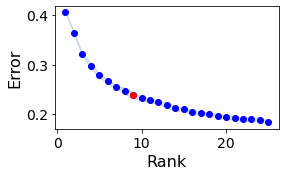

In [9]:
%%time
fig, error = tensor.elbow_rank_selection(upper_rank=25,
                                         runs=10,
                                         init='random',
                                         automatic_elbow=True,
                                         random_state=888                                        
                                        )

**Tensor decomposition**

In [10]:
tensor.compute_tensor_factorization(rank=tensor.rank,
                                    init='random',
                                    random_state=888)

# Results

**Plot factors**

In [11]:
cmaps = ['plasma', 'Dark2_r', 'tab20', 'tab20']

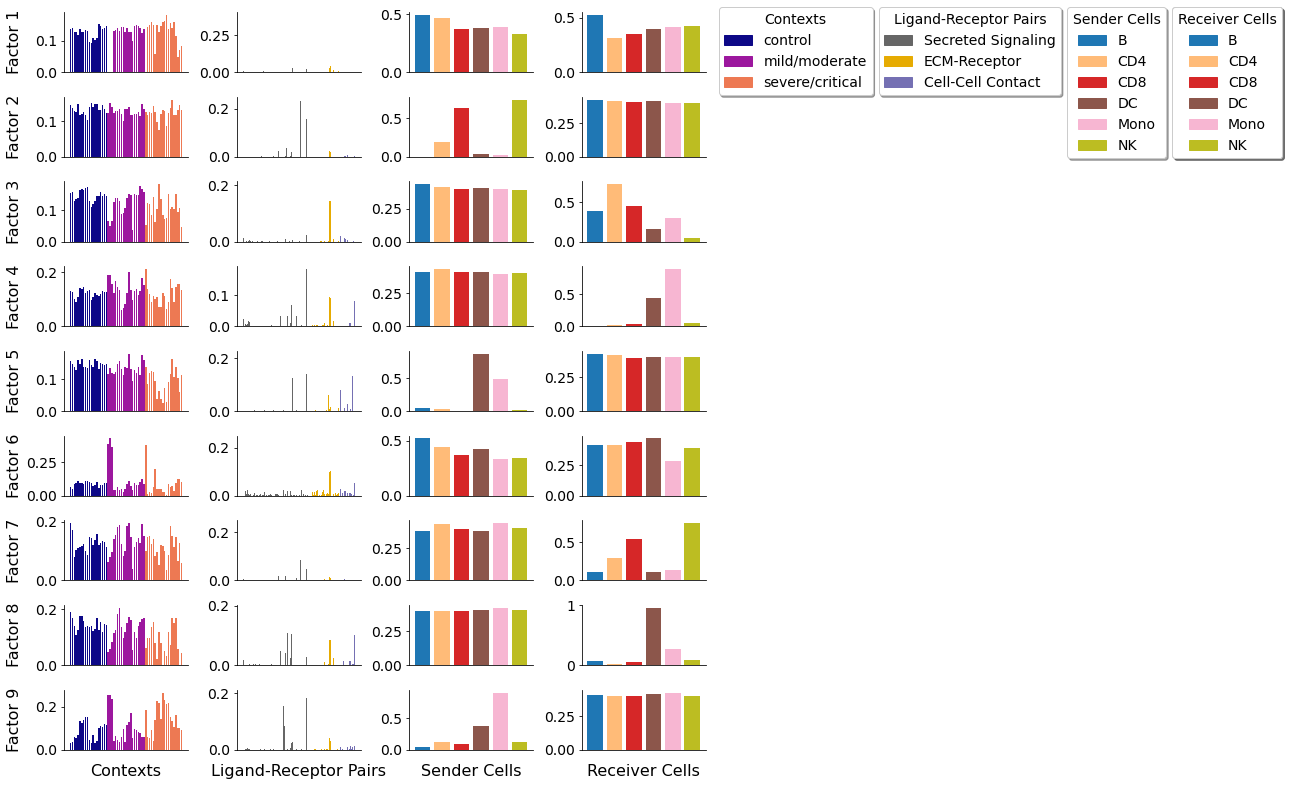

In [12]:
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             metadata = meta_tf,
                                             sample_col='Element',
                                             group_col='Category',
                                             meta_cmaps=cmaps,
                                             fontsize=14,
                                            )

**Top genes in each factor**

In [13]:
for i in range(tensor.rank):
    print(tensor.get_top_factor_elements('Ligand-Receptor Pairs', 'Factor {}'.format(i+1), 10))
    print('')

CLDN11^CLDN11         0.388252
TNFSF13B^TNFRSF13C    0.283787
TNFSF13B^TNFRSF13B    0.259462
MIF^CD74&CXCR4        0.257225
APP^CD74              0.252512
TNFSF13B^TNFRSF17     0.226178
MIF^CD74&CD44         0.216462
CD22^PTPRC            0.206389
CD99^CD99             0.184401
MIF^CD74&CXCR2        0.173624
Name: Factor 1, dtype: float32

GZMA^F2RL3    0.237451
GZMA^F2RL2    0.236482
GZMA^F2RL1    0.236081
GZMA^PARD3    0.234784
GZMA^F2R      0.233763
CCL5^CCR5     0.221572
CCL5^CCR4     0.220826
CCL5^ACKR2    0.220762
CCL5^CCR1     0.220081
CCL5^CCR3     0.219417
Name: Factor 2, dtype: float32

MIF^CD74&CD44     0.203979
CLDN11^CLDN11     0.192775
MIF^CD74&CXCR4    0.165362
LGALS9^CD44       0.157485
COL6A2^CD44       0.143196
COL1A2^CD44       0.142996
COL9A3^CD44       0.142932
LAMC1^CD44        0.142293
COL4A5^CD44       0.142192
COL9A2^CD44       0.141815
Name: Factor 3, dtype: float32

ANXA1^FPR1       0.185668
CD99^PILRA       0.169576
CSF3^CSF3R       0.166432
MDK^LRP1        